# A Novel Deep Learning Approach for Wind Power Forecasting Based on WD-LSTM Model

## Import all the needed packages

In [1]:
# Basic Data Science Packages
import numpy as np
import pandas as pd

#TensorFlow packages required for building CNN + LSTM model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Input, Dense, LSTM, Reshape
from tensorflow.keras.models import Sequential

#Plotting graph
import matplotlib.pyplot as plt

#Plotting Keras Model
from tensorflow.keras.utils import plot_model

import pywt

#Normalization of data
from sklearn.preprocessing import StandardScaler

#Utility Module for computing and displaying metrics
from utility_functions import metrics

import warnings
warnings.filterwarnings("ignore")

## Performing Wavelength Decomposition

In [2]:
db3 = pywt.Wavelet('db3')
scaler = StandardScaler()
def normalizeAndDecompose(df_input):
    df = pd.DataFrame(df_input)
    normalized_df =  scaler.fit_transform(df)
    decomposed_df = pywt.wavedec2(normalized_df, db3)
    normalized_decomposed_df = pd.DataFrame(np.concatenate(decomposed_df))
    for index, name in enumerate(df.columns):
            df[name] = normalized_decomposed_df[index].values
    
    return df if isinstance(df_input, pd.DataFrame) else df.squeeze()

In [3]:
def inverse_normalizeAndDecompose(df_input):
    df = pd.DataFrame(df_input)
    return np.concatenate(pywt.wavedec2(scaler.inverse_transform(df), db3))

## Import the data and split into Train, Test and Validation
- Fetch the first 70% records as train and the rest 15% each as validation and test
    - 8711 * 70% = 6097 records from the start (Train)
    - 6097 + 1307 = 6098 to 7404 records as (Validation)
    - 7404 + 1307 = 7405 to 8711 records as (Test)

In [4]:
thesis_dataset = pd.read_csv('data/final_thesis_dataset.csv',parse_dates=[0], index_col=0)

#Extracting dataset into train, validation and test sets
train = thesis_dataset[:6097]
valid = thesis_dataset[6097:7404]
test = thesis_dataset[7404:]

#Extracting solar and wind X, y columns per set
X_solar_train = normalizeAndDecompose(train[['SWTDN', 'SWGDN', 'T']])
y_solar_train = normalizeAndDecompose(train['DE_solar_generation_actual'])
X_solar_valid = normalizeAndDecompose(valid[['SWTDN', 'SWGDN', 'T']])
y_solar_valid = normalizeAndDecompose(valid['DE_solar_generation_actual'])
X_solar_test = normalizeAndDecompose(test[['SWTDN', 'SWGDN', 'T']])
y_solar_test = normalizeAndDecompose(test['DE_solar_generation_actual'])

X_wind_train = normalizeAndDecompose(train[['v1', 'v2', 'v_50m', 'z0']])
y_wind_train = normalizeAndDecompose(train['DE_wind_generation_actual'])
X_wind_valid = normalizeAndDecompose(valid[['v1', 'v2', 'v_50m', 'z0']])
y_wind_valid = normalizeAndDecompose(valid['DE_wind_generation_actual'])
X_wind_test = normalizeAndDecompose(test[['v1', 'v2', 'v_50m', 'z0']])
y_wind_test = normalizeAndDecompose(test['DE_wind_generation_actual'])

## Building the Model using LSTM layer and Fully Connected Layer

In [5]:
model = Sequential()
#Mapping to the input size
model.add(Input(shape=(3,)))
#Reshaping for the RNN Layer to perform
model.add(Reshape((-1,1)))
#Creating 2 LSTMs with 64 units and relu Activation
model.add(LSTM(64, activation = 'relu', input_shape = X_solar_train.shape, return_sequences=True))
model.add(LSTM(64, activation = 'relu', return_sequences=False))
#Attaching a Dense Layer of the same unit size
model.add(Dense(64))
#Batch Normalization on the output from the dense layer
model.add(BatchNormalization())
#Extracting single output using Dense of 1
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3, 1)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 3, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 54,401
Trainable params: 54,273
Non-trainable params: 128
__________________________________________________

## Compiling the model by passing adam optimizer, loss=MAE and fetching accuracy metrics

In [6]:
model.compile('adam', 'mean_absolute_error', ['accuracy'])
history = model.fit(X_solar_train, y_solar_train, epochs = 15, validation_data = (X_solar_valid, y_solar_valid))

Epoch 1/15
191/191 [==============================] - 5s 15ms/step - loss: 0.2924 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 2/15
191/191 [==============================] - 1s 4ms/step - loss: 0.2165 - accuracy: 0.0000e+00 - val_loss: 0.5747 - val_accuracy: 0.0000e+00
Epoch 3/15
191/191 [==============================] - 1s 4ms/step - loss: 0.2090 - accuracy: 0.0000e+00 - val_loss: 0.3515 - val_accuracy: 0.0000e+00
Epoch 4/15
191/191 [==============================] - 1s 4ms/step - loss: 0.2113 - accuracy: 0.0000e+00 - val_loss: 0.1910 - val_accuracy: 0.0000e+00
Epoch 5/15
191/191 [==============================] - 1s 3ms/step - loss: 0.2107 - accuracy: 0.0000e+00 - val_loss: 0.3919 - val_accuracy: 0.0000e+00
Epoch 6/15
191/191 [==============================] - 1s 3ms/step - loss: 0.2020 - accuracy: 0.0000e+00 - val_loss: 0.2284 - val_accuracy: 0.0000e+00
Epoch 7/15
191/191 [==============================] - 1s 4ms/step - loss: 0.2008 - accuracy: 0.0000

In [7]:
model.evaluate(X_solar_test, y_solar_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.1946 - accuracy: 0.0000e+00


[0.19457578659057617, 0.0]

### Plotting the Keras model

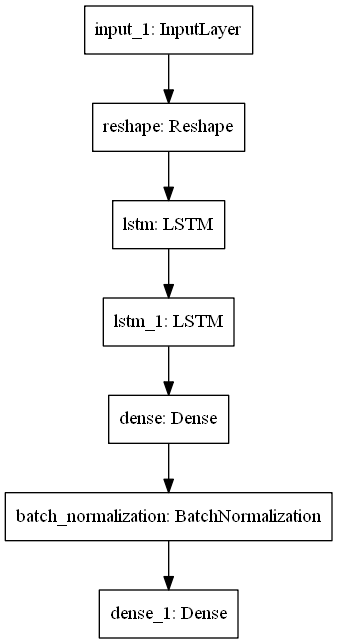

In [8]:
plot_model(
    model, to_file='figs/4-model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

## Plotting Model's Accuracy and Loss Metrics over Train and Validation sets for Solar

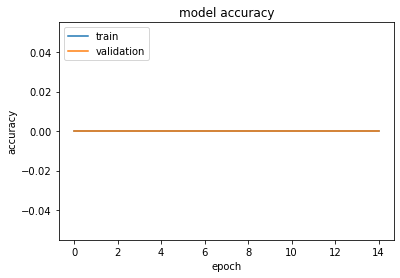

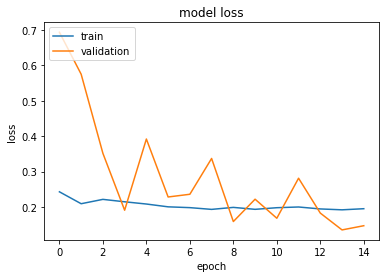

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plotting Actual vs Predictions on the same plot

In [10]:
train_solar_pred = model.predict(X_solar_train)
val_solar_pred = model.predict(X_solar_valid)
test_solar_pred = model.predict(X_solar_test)

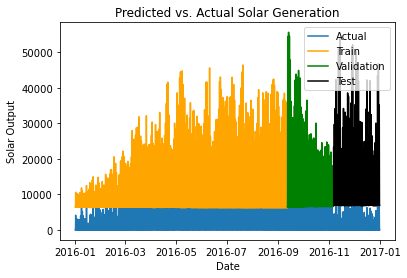

In [11]:
df = thesis_dataset[['DE_solar_generation_actual']]

train_df = train[['DE_solar_generation_actual']]
train_df.loc[:, 'DE_solar_generation_actual'] = inverse_normalizeAndDecompose(train_solar_pred)

valid_df = valid[['DE_solar_generation_actual']]
valid_df.loc[:, 'DE_solar_generation_actual'] = inverse_normalizeAndDecompose(val_solar_pred)

test_df = test[['DE_solar_generation_actual']]
test_df.loc[:, 'DE_solar_generation_actual'] = inverse_normalizeAndDecompose(test_solar_pred)

# Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
train_solar_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_solar_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_solar_predx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Solar Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Solar Generation")
plt.show()

## Regression Metrics for Solar

In [12]:
metrics('wd-lstm', test[['DE_solar_generation_actual']], inverse_normalizeAndDecompose(test_solar_pred))

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
wd-lstm,10992.177476,13233.377565,115.036418,4.745249,-30.572293


## Modelling and Fitting the model for Wind Dataset

In [13]:
model = Sequential()
model.add(Input(shape=(4,)))
model.add(Reshape((-1,1)))
#Creating 2 LSTMs with 64 units and relu Activation
model.add(LSTM(64, activation = 'relu', input_shape = X_wind_train.shape, return_sequences=True))
model.add(LSTM(64, activation = 'relu', return_sequences=False))
#Attaching a Dense Layer of the same unit size
model.add(Dense(64))
#Batch Normalization on the output from the dense layer
model.add(BatchNormalization())
#Extracting single output using Dense of 1
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 4, 1)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 64)             16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 54,401
Trainable params: 54,273
Non-trainable params: 128
________________________________________________

In [14]:
model.compile('adam', 'mse', ['accuracy'])
history = model.fit(X_wind_train, y_wind_train, validation_data=(X_wind_valid, y_wind_valid), epochs=15)

Epoch 1/15
191/191 [==============================] - 7s 11ms/step - loss: 0.2268 - accuracy: 0.0000e+00 - val_loss: 0.8588 - val_accuracy: 0.0000e+00
Epoch 2/15
191/191 [==============================] - 1s 7ms/step - loss: 0.1515 - accuracy: 0.0000e+00 - val_loss: 0.6977 - val_accuracy: 0.0000e+00
Epoch 3/15
191/191 [==============================] - 1s 6ms/step - loss: 0.1185 - accuracy: 0.0000e+00 - val_loss: 0.3377 - val_accuracy: 0.0000e+00
Epoch 4/15
191/191 [==============================] - 1s 4ms/step - loss: 0.1018 - accuracy: 0.0000e+00 - val_loss: 0.1204 - val_accuracy: 0.0000e+00
Epoch 5/15
191/191 [==============================] - 1s 5ms/step - loss: 0.1080 - accuracy: 0.0000e+00 - val_loss: 0.0934 - val_accuracy: 0.0000e+00
Epoch 6/15
191/191 [==============================] - 1s 5ms/step - loss: 0.1072 - accuracy: 0.0000e+00 - val_loss: 0.1561 - val_accuracy: 0.0000e+00
Epoch 7/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0993 - accuracy: 0.0000

In [15]:
model.evaluate(X_wind_test, y_wind_test)

41/41 [==============================] - 0s 8ms/step - loss: 0.0771 - accuracy: 0.0000e+00


[0.07705289870500565, 0.0]

## Model's Accuracy and Loss for Wind Dataset

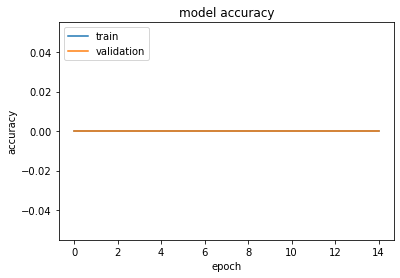

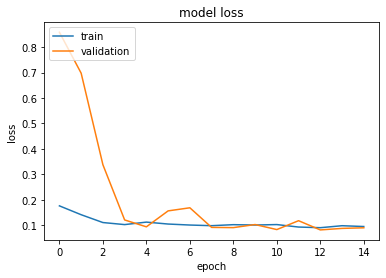

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plotting Actual vs Predicted for Wind on same graph

In [17]:
train_wind_pred = model.predict(X_wind_train)
val_wind_pred = model.predict(X_wind_valid)
test_wind_pred = model.predict(X_wind_test)

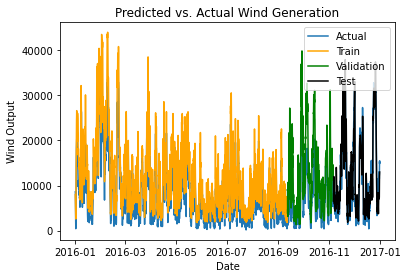

In [18]:
df = thesis_dataset[['DE_wind_generation_actual']]

train_df = train[['DE_wind_generation_actual']]
train_df.loc[:, 'DE_wind_generation_actual'] = inverse_normalizeAndDecompose(train_wind_pred)

valid_df = valid[['DE_wind_generation_actual']]
valid_df.loc[:, 'DE_wind_generation_actual'] = inverse_normalizeAndDecompose(val_wind_pred)

test_df = test[['DE_wind_generation_actual']]
test_df.loc[:, 'DE_wind_generation_actual'] = inverse_normalizeAndDecompose(test_wind_pred)

# Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
train_wind_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_wind_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_wind_predx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Wind Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Wind Generation")
plt.show()

### Regression Metrics for Wind

In [19]:
metrics('wd-lstm', test[['DE_wind_generation_actual']], inverse_normalizeAndDecompose(test_wind_pred))

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
wd-lstm,1921.926456,2399.594284,48.985654,3.891527,0.922947
